In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')
sys.path.append("/Users/marissac/Documents/COCOText/coco-text-master")
import caffe
import coco_text
import coco_evaluation
import skimage.io as io
#caffe.set_device(0)
#caffe.set_mode_cpu()

from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL COCO labels
coco_labelmap_file = '/Users/marissac/caffe/data/coco/labelmap_cocoText.prototxt'
file = open(coco_labelmap_file, 'r')
coco_labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), coco_labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    print num_labels
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

model_def = '/Users/marissac/caffe/models/VGGNet/cocoText/SSD_300x300/deploy_selectDigit.prototxt'
model_weights = '/Users/marissac/caffe/examples/ssd/models/VGGNet/cocoText/SSD_300x300/VGG_cocoText_SSD_300x300_iter_140000.caffemodel'
model_net = '/Users/marissac/caffe/models/VGGNet/cocoText/SSD_300x300/test.prototxt'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)
net_test = caffe.Net(model_net,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB



In [2]:
dataDir='/Users/marissac/data/coco'
dataType='train2014'

imgSize = 300

ct = coco_text.COCO_Text('/Users/marissac/data/coco/annotations/COCO_Text.json')
#ct.scaleGroundTruth(imgSize,imgSize)
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.val, 
                    catIds=[('legibility','legible'),('language','english')])


loading annotations into memory...
0:00:02.583607
creating index...
index created!


/images/train2014/COCO_train2014_000000246587.jpg
2


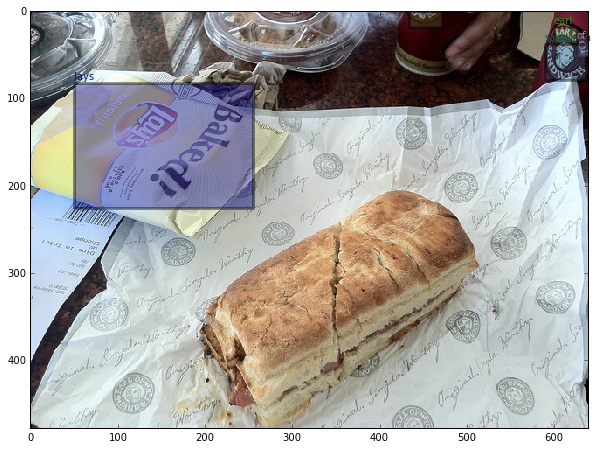

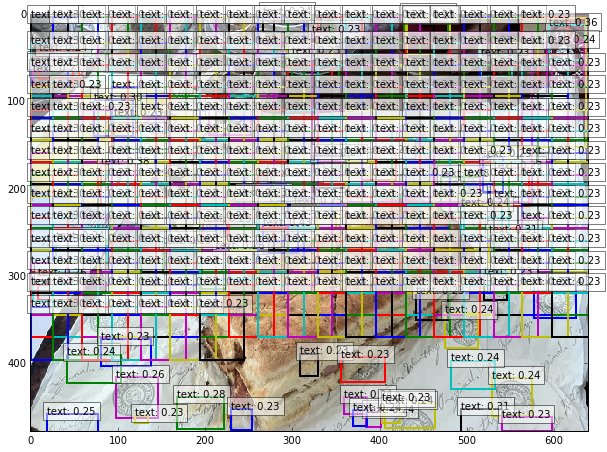

In [3]:
# pick one at random
#img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
#net_test.forward()
#test_image = net_test.blobs['data'].data



imgNumTest = 246587
img = ct.loadImgs(imgNumTest)[0]
print '/images/%s/%s'%(dataType,img['file_name'])

image = caffe.io.load_image('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
#plt.figure()
#plt.imshow(image)
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
#ct.showAnns(anns)


# set net to batch size of 1
image_resize = 300
net.blobs['data'].reshape(1,3,image_resize,image_resize)

transformed_image = transformer.preprocess('data',image)
net.blobs['data'].data[...] = transformed_image
#net.blobs['data'].data[...] = test_image
# Forward pass.
net.forward()

detections = net.blobs['detection_out'].data
#detections = net.forward()['detection_out']

#image = caffe.io.load_image('/Users/marissac/caffe/examples/images/cat.jpg')
#image_blob = net.blobs['data'].data
#image = transformer.deprocess('data', test_image)
#image_resize = 300

#imageTemp = image;

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]


# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.22]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(coco_labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]



colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.figure()
plt.imshow(image)
ct.showAnns(anns)

plt.figure()
plt.imshow(image)
currentAxis = plt.gca()

#detect_bbox = zeros((top_conf.shape[0],1))
detect_bbox ={}

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    
    top_xmin_pix = top_xmin[i] * image.shape[1]
    top_ymin_pix = top_ymin[i] * image.shape[0]
    top_width_pix = top_xmax[i] * image.shape[1] - top_xmin_pix
    top_height_pix = top_ymax[i] * image.shape[0] - top_ymin_pix
    bboxTemp = [top_xmin_pix, top_ymin_pix,top_width_pix,top_height_pix]
    #detect_bbox.append({'bbox':bboxTemp,'label':i})
    detect_bbox[i] = {'bbox':bboxTemp,'label':i}
    score = top_conf[i]
    label = top_labels[i]
    name = '%s: %.2f'%(label, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[i % len(colors)]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.5})
    
#print det_conf
    

In [4]:
# Get detection scores
gt_bboxes = annIds
eval_bboxes = detect_bbox
detection_threshold_use = 0.5

iouSave = np.zeros((len(gt_bboxes),top_conf.shape[0]))
detectRes = {}
# results are lists of dicts {gt_id: xxx, eval_id: yyy}
detectRes['true_positives'] = []
detectRes['false_negatives'] = []
detectRes['false_positives'] = []
    
count = 0
for gt_box_id in range(0,len(gt_bboxes)):
    gt_box = anns[gt_box_id]['bbox']
    max_iou = detection_threshold_use
    match = None
    count2 = 0
    for eval_box_id in eval_bboxes:
        eval_box = eval_bboxes[eval_box_id]['bbox']
        #eval_box = eval_box_id['bbox']
        iouSave[count,count2] = coco_evaluation.iou_score(gt_box,eval_box)
        if iouSave[count,count2] > max_iou:
            match = eval_box_id
            max_iou = iouSave[count,count2]
        count2 = count2+1
    if match is not None:
        detectRes['true_positives'].append({'gt_id': gt_box_id, 'eval_id': eval_box_id})
        del eval_bboxes[eval_box_id]
        #eval_bboxes.remove(eval_box_id)
    else:
        detectRes['false_negatives'].append({'gt_id': gt_box_id})
    count = count +1

print len(eval_bboxes)
if len(eval_bboxes)>0:
    for i in range(0,len(eval_bboxes)):
        detectRes['false_positives'].append({'eval_id': eval_bboxes[i]['label'] })
    
print(iouSave)
print(detectRes)

# Compute precision and recall for each image
found = [x['gt_id'] for x in detectRes['true_positives']]
n_found = [x['gt_id'] for x in detectRes['false_negatives']]
fp = [x['eval_id'] for x in detectRes['false_positives']]

if len(found) >0:
    precision = 100*len(found)*1.0/len(found+fp)
    recall = 100*len(found)*1.0/len(found+n_found)
    print precision
    print recall

299
[[ 0.          0.          0.05983854 ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
{'false_positives': [{'eval_id': 0}, {'eval_id': 1}, {'eval_id': 2}, {'eval_id': 3}, {'eval_id': 4}, {'eval_id': 5}, {'eval_id': 6}, {'eval_id': 7}, {'eval_id': 8}, {'eval_id': 9}, {'eval_id': 10}, {'eval_id': 11}, {'eval_id': 12}, {'eval_id': 13}, {'eval_id': 14}, {'eval_id': 15}, {'eval_id': 16}, {'eval_id': 17}, {'eval_id': 18}, {'eval_id': 19}, {'eval_id': 20}, {'eval_id': 21}, {'eval_id': 22}, {'eval_id': 23}, {'eval_id': 24}, {'eval_id': 25}, {'eval_id': 26}, {'eval_id': 27}, {'eval_id': 28}, {'eval_id': 29}, {'eval_id': 30}, {'eval_id': 31}, {'eval_id': 32}, {'eval_id': 33}, {'eval